# Modeling the process of gold mining

In [1]:
import pandas as pd
import numpy as np
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor

In [2]:
# function to calculate the effectivenes of recovery

def recovery(data):
    C = data['rougher.output.concentrate_au']
    F = data['rougher.input.feed_au']
    T = data['rougher.output.tail_au']
    return ((C*(F-T))/(F*(C-T)))*100

In [3]:
# function to visualize how concentration of metals (AU, AG, PB) varies at different stages of cleaning

def concentrate_plotting(data, metal_name: str):
    start_point_name = 'rougher.input.feed_' + metal_name
    rougher_name = 'rougher.output.concentrate_' + metal_name
    primary_clean_name = 'primary_cleaner.output.concentrate_' + metal_name
    secondary_clean_name = 'final.output.concentrate_' + metal_name
    
    start_point = data[start_point_name].mean()
    rougher = data[rougher_name].mean()
    primary_cleaner = data[primary_clean_name].mean()
    secondary_cleaner = data[secondary_clean_name].mean() 
    
    df = pd.DataFrame([start_point, rougher, primary_cleaner, secondary_cleaner], columns=['mean'], index = [start_point_name, rougher_name, primary_clean_name, secondary_clean_name])
    
    return sns.barplot(x = df.index, y = df['mean'], data=df, ax=ax)

In [4]:
# function to visualize how distribution of the concentration of metals (Au, Ag, Pb) varies at different stages of cleaning

def concentrate_distributions(data, metal_name: str, color: str):
    
    start_point_name = 'rougher.input.feed_' + metal_name
    rougher_name = 'rougher.output.concentrate_' + metal_name
    primary_clean_name = 'primary_cleaner.output.concentrate_' + metal_name
    secondary_clean_name = 'final.output.concentrate_' + metal_name
    
    col_names = [start_point_name, rougher_name, primary_clean_name, secondary_clean_name]
    _, axs = plt.subplots(2, 2, figsize=(15,10))
    axs = axs.ravel()    
    
    for i in range(len(col_names)):
        ax = axs[i]
        sns.histplot(ax=ax, x=df_full[col_names[i]], color=color)
        ax.tick_params(axis='x')
        ax.set_title(metal_name.capitalize() + ' ' + col_names[i])

In [5]:
# function to get a unique date of experiment (needed to remove outliers)

date = []
def date_picker(rows):
    rougher_output = rows['rougher.output.sum']
    final_output = rows['final.output.sum']
    
    if (rougher_output == 0) or (final_output == 0):
        return date.append(rows['date'])

In [6]:
# Symmetric Mean Absolute Percentage Error (loss function)

def smape(y_true, y_pred):
    error = np.abs(y_true - y_pred)
    scale = (np.abs(y_true) + np.abs(y_pred))/2
    return np.mean(error/scale)*100

In [7]:
# function for calculating the final metric

def final_smape(rougher, final):
    return 0.25*rougher + 0.75*final

## Data preprocessing

Let's open files and examine them. All variables have float data type except for the string variable `date` - the unique date of the experiment.

In [8]:
try:
    df_full = pd.read_csv('/Users/anshilina/Downloads/gold_recovery_full_new.csv')
    df_train = pd.read_csv('/Users/anshilina/Downloads/gold_recovery_train_new.csv')    
    df_test = pd.read_csv('/Users/anshilina/Downloads/gold_recovery_test_new.csv')
except:
    df_full = pd.read_csv('/datasets/gold_recovery_full_new.csv')
    df_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')    
    df_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')

In [9]:
display.display(df_full.head(3))

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363


In [10]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


Let's examine distributions of target variables: `rougher.output.recovery` and `final.output.recovery`. Distributions are left-skewed and are close to normal.

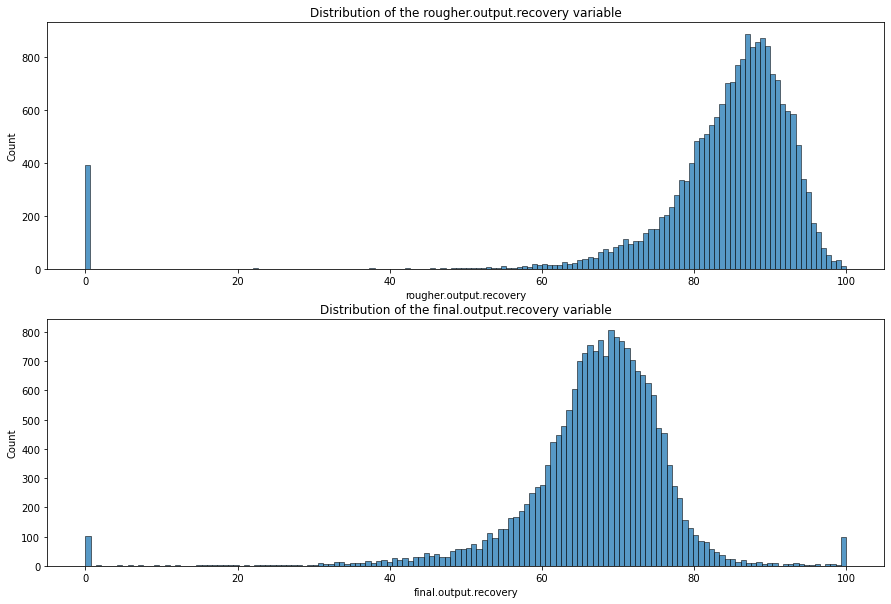

In [11]:
col_names = ['rougher.output.recovery', 'final.output.recovery']
col_titles = ['Distribution of the rougher.output.recovery variable', 
              'Distribution of the final.output.recovery variable']

_, axs = plt.subplots(2, 1, figsize=(15,10))
axs = axs.ravel()

for i in range(len(col_names)):
    ax = axs[i]
    sns.histplot(ax=ax, x=df_full[col_names[i]])
    ax.tick_params(axis='x')
    ax.set_title(col_titles[i])
    

Let's study the independent variables (features). It is worth noting that many variables are different in scale. This will not affect the quality of decision trees and random forest models, but for linear regression it will be necessary to scale the features.

In [12]:
display.display((df_full.describe()))

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,19438.000000,19438.000000,19228.000000,19439.000000,19439.000000,19438.000000,19338.000000,19433.000000,19439.000000,19415.000000,...,19433.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19437.000000,19438.000000
mean,5.168470,9.978895,9.501224,44.076513,67.050208,9.688589,2.705795,10.583728,3.042467,144.624774,...,18.987674,-485.894516,15.010366,-461.078636,15.694452,-488.684065,12.198224,-487.149827,18.959024,-505.436305
std,1.372348,1.669240,2.787537,5.129784,10.125840,2.328642,0.949077,2.868782,0.922808,44.464071,...,5.411058,47.758570,4.890228,67.405524,5.510974,34.533396,5.333024,38.347312,5.550498,37.689057
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003112,...,0.000000,-799.798523,0.000000,-800.836914,-0.372054,-797.323986,0.528083,-800.220337,-0.079426,-809.741464
25%,4.251240,9.137262,7.722820,43.402215,63.299712,8.062878,2.040119,8.938947,2.461138,114.107029,...,14.975734,-500.704892,11.940294,-500.187742,10.988606,-500.458467,8.971105,-500.129462,14.983037,-500.728067
50%,5.066094,10.102433,9.218961,45.011244,68.172738,9.743623,2.748730,10.622456,2.984909,143.232103,...,18.017481,-499.837793,14.971014,-499.459786,15.000036,-499.802605,11.019433,-499.935317,19.960541,-500.048400
75%,5.895527,11.035769,10.947813,46.275313,72.686642,11.134294,3.333216,12.104271,3.571351,175.075656,...,23.012470,-498.249730,19.034162,-400.118106,18.026190,-498.384187,14.019088,-499.436708,24.003170,-499.495378
max,16.001945,17.031899,19.615720,52.756638,100.000000,19.552149,5.804178,22.317730,8.245022,265.983123,...,30.115735,-245.239184,31.269706,-6.506986,43.709931,-244.483566,27.926001,-137.740004,32.188906,-104.427459


Let's check that the efficiency of recovery is calculated correctly. Let's calculate it on the train sample for the feature `rougher.output.recovery` and find MAE between our calculations and the real value.

Recovery efficiency is calculated by the formula: (C*(F-T))/(F*(C-T)), where:

* C — proportion of gold in concentrate after rougher/cleaner, variable `rougher.output.concentrate_au`
* F — proportion of gold in feed/concentrate before rougher/cleaner, variable `rougher.input.feed_au`
* T — proportion of gold in final tailing after rougher/cleaner, variable`rougher.output.tail_au`

For calculation we will use the `recovery` function. Then we visualize the distributions.

In [13]:
df_recovery = pd.DataFrame(recovery(df_train), columns=['recovery_calc']) # используем функцию
df_recovery['recovery_true'] = df_train['rougher.output.recovery']
display.display(df_recovery.head())
print('MAE:', round(mean_absolute_error(df_recovery['recovery_true'], df_recovery['recovery_calc']), 5))

,recovery_calc,recovery_true
0,87.107763,87.107763
1,86.843261,86.843261
2,86.842308,86.842308
3,87.226430,87.226430
4,86.688794,86.688794


MAE: 0.0


Now let's analyze the features that are not available in the test sample. There are no target features in the test sample - `rougher.output.recovery` and `final.output.recovery` (efficiency of the rough and final concentrate recovery respectively). We will keep them in the train sample as they will be needed to train the model. 

All other features that are available in the train sample but are not available in the test are observations obtained after the process was launched. In other words, these are either the parameters (`output`) of the product obtained at one of the flotation stages (concentrate or final tailings after flotation, primary and secondary cleaner), or the characteristics (`calculation`) calculated at the rougher stage: the ratio of sulfate to gold in concentrate, the ratio of sulfate to gold in feed in 10 and 11 floatbanks, the ratio of gold to plumbum.

**Summary:** Since these features are **not observed at the decision-making stage**, but observed after the process has been started, we should not use them to train the model - otherwise we will face a data leakage problem. Therefore, we will remove these features from the train sample before training the model.

In [14]:
different_vars = [var for var in df_train.columns if var not in df_test.columns]
display.display(different_vars)

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

Now let's preprocess the data: examine missing values and duplicates, drop them if necessary.

In [15]:
print('Number of duplicates:', df_full.duplicated().sum())
print('Shape of data frame:', df_full.shape)
print('Number of missing values:', df_full.isna().sum().sum())

Number of duplicates: 0
Shape of data frame: (19439, 87)
Number of missing values: 4481


Let's look at the variables with missing values.

In [16]:
df_na = pd.DataFrame(df_full.isna().sum(), columns=['sum_na']).sort_values(by='sum_na', ascending=False)
df_na = df_na.query('sum_na > 0')
display.display(df_na.head(25))

,sum_na
secondary_cleaner.output.tail_sol,1748
rougher.input.floatbank11_xanthate,453
rougher.state.floatbank10_e_air,436
primary_cleaner.output.concentrate_sol,370
secondary_cleaner.state.floatbank2_a_air,220
final.output.concentrate_sol,211
rougher.input.feed_size,145
primary_cleaner.output.concentrate_pb,116
primary_cleaner.input.xanthate,104
final.output.tail_pb,101


Since features of experiments carried out sequentially are similar, we can fill in missing values either with the previous ones in the column (the `bfill` method) or the following ones (the `ffill` method). We decided to fill the missing values in the full data set and in the train sample using `ffill` method. We will not fill the missing values in the test sample, and before checking model on the test, we will remove them using the `dropna` method. Thus, we will minimize our impact on the test sample.

In [17]:
df_full = df_full.fillna(method='ffill').copy()
df_train = df_train.fillna(method='ffill').copy()

print('Number of missing values in full df:', df_full.isna().sum().sum())
print('Number of missing values in train df:', df_train.isna().sum().sum())

Number of missing values in full df: 0
Number of missing values in train df: 0


We also observe high multicollinearity in the data. Similar in type or interconnected processes are highly correlated - it is normal and natural. Multicollinearity should not affect the quality of the decision tree or random forest models, but it can greatly affect the results of linear regression. Therefore, in this study we attempted to remove some of the highly correlated features. This did not help improve the quality of the linear models (in some cases it got worse). Therefore, we decided to keep all features in data frame. This stage was omitted from the project.

In [18]:
df_corr = df_full.corr().abs().unstack().drop_duplicates()
df_corr[(df_corr > 0.7) & (df_corr != 1)].sort_values(ascending=False)

rougher.state.floatbank10_b_level                   rougher.state.floatbank10_c_level                     0.987836
rougher.state.floatbank10_e_level                   rougher.state.floatbank10_f_level                     0.980917
rougher.state.floatbank10_c_level                   rougher.state.floatbank10_d_level                     0.980911
rougher.state.floatbank10_b_level                   rougher.state.floatbank10_d_level                     0.971205
rougher.calculation.floatbank10_sulfate_to_au_feed  rougher.calculation.floatbank11_sulfate_to_au_feed    0.965838
rougher.state.floatbank10_c_level                   rougher.state.floatbank10_e_level                     0.962116
primary_cleaner.state.floatbank8_a_air              primary_cleaner.state.floatbank8_b_air                0.953132
rougher.state.floatbank10_c_level                   rougher.state.floatbank10_f_level                     0.952531
rougher.state.floatbank10_b_level                   rougher.state.floatbank10_e_

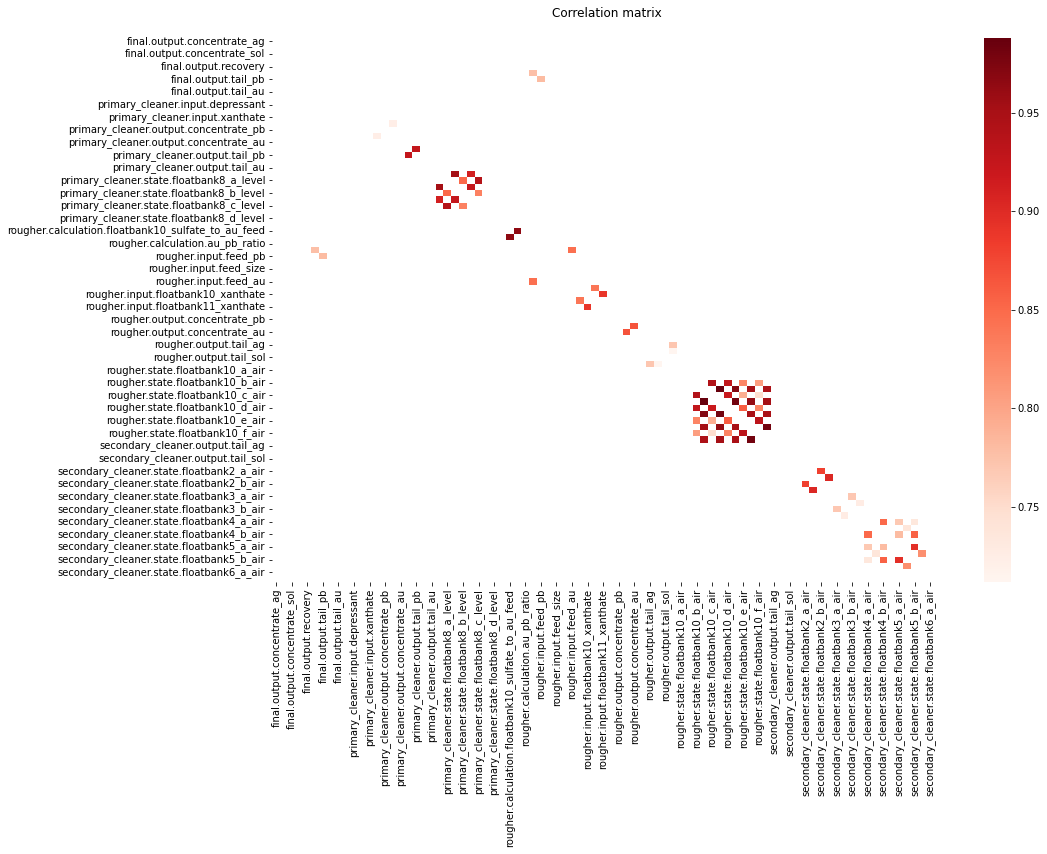

In [19]:
df_corr = df_full.corr().abs()
filteredDf = df_corr[(df_corr >= .7) & (df_corr !=1.000)]
plt.figure(figsize=(15,10))
sns.heatmap(filteredDf, cmap="Reds")
plt.title('Correlation matrix\n')
plt.show()

## Data analysis

Now we will study how the concentration of metals (Au, Ag, Pb) changes at various stages of rougher and cleaner. Firstly, let's consider how the concentration of each metal changes on average at each stage. We see that the concentration of gold and plumbum is increasing, while the concentration of silver is declining.

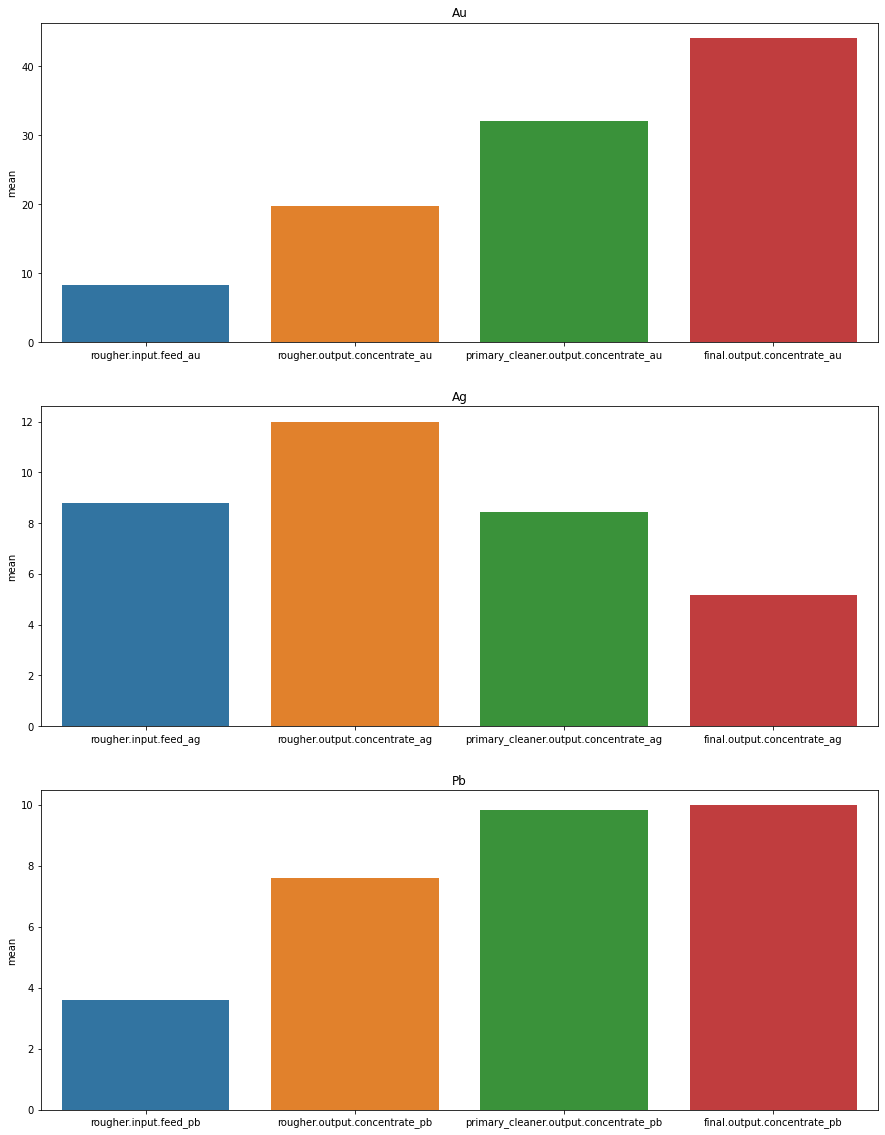

In [20]:
metal_name = ['au', 'ag', 'pb']
_, axs = plt.subplots(3, 1, figsize=(15,20))
axs = axs.ravel()

for i in range(len(metal_name)):
    ax = axs[i]
    concentrate_plotting(df_full, metal_name[i])
    ax.tick_params(axis='x')
    ax.set_title(metal_name[i].capitalize())

Next, let's look at the distribution of the concentration of metals (Au, Ag, Pb) at various stages of rougher and cleaner. The first graph is the distribution of feed, the second-fourth graph is the distribution of metals at each stage of flotation. For each of the three metals, we can observe outliers at zero.

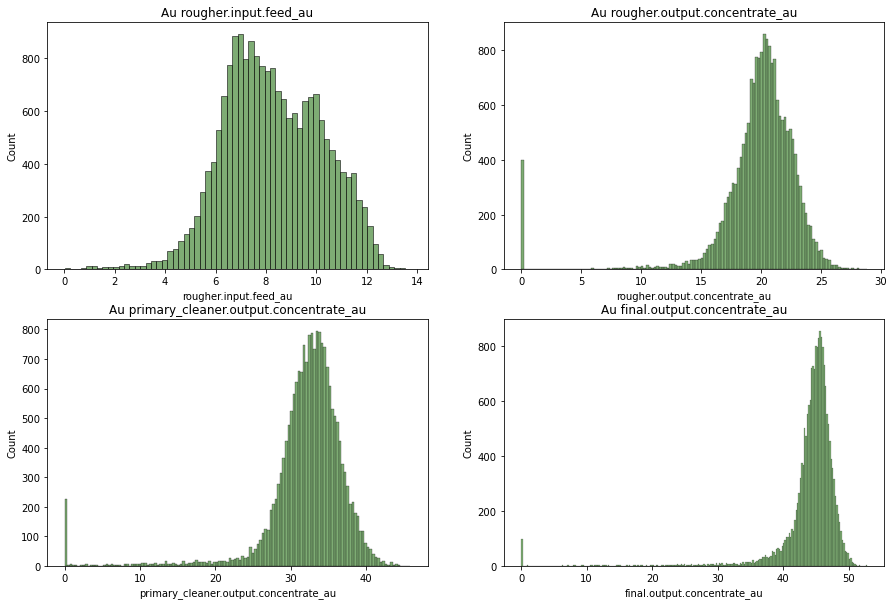

In [21]:
concentrate_distributions(df_full, 'au', '#539045')
plt.show()

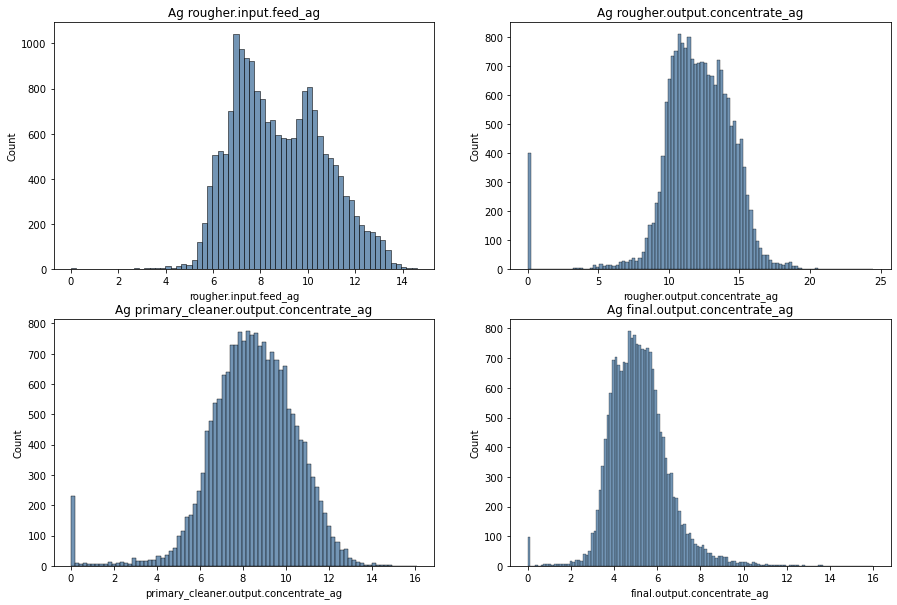

In [22]:
concentrate_distributions(df_full, 'ag', '#44729d')
plt.show()

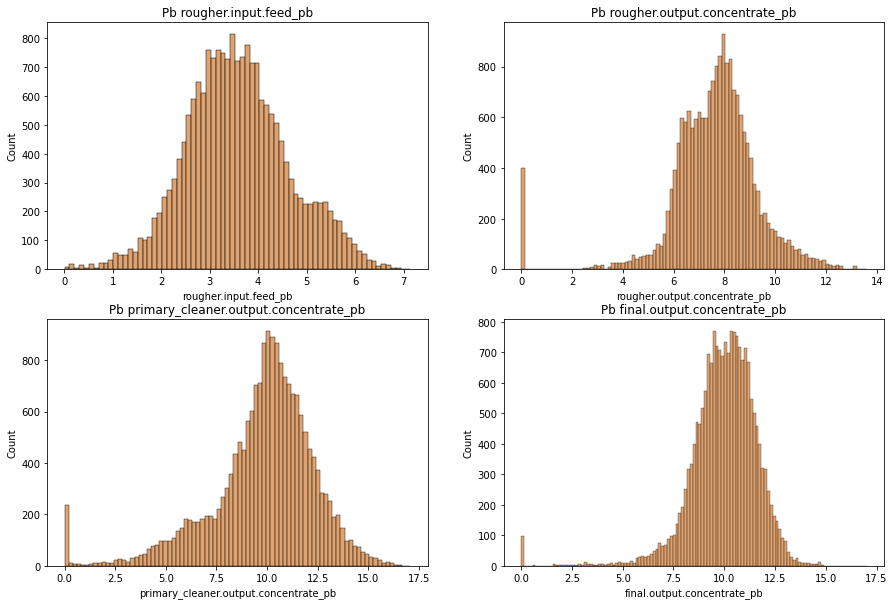

In [23]:
concentrate_distributions(df_full, 'pb', '#d48540')
plt.show()

**Summary:** These outliers at zeros can affect the quality of the model. At this stage, we decided to pay attention to them and, if necessary, exclude them from the train sample.

Now let's compare the grain size distributions in the train and test samples. If distributions are significantly differ, the estimation we obtain from the model will be wrong. 

Since train and test samples are of different sizes, we need to compare densities, therefore, we will use the `stat='density'` parameter.

At the rougher stage, grain size distributions in the train and test samples are similar - they are right-skewed.

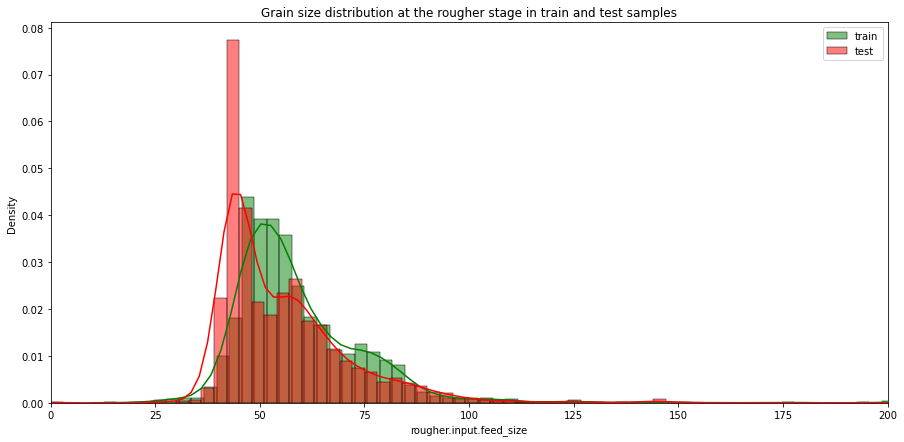

In [24]:
plt.figure(figsize=(15,7))
sns.histplot(x=df_train['rougher.input.feed_size'], binwidth=3, kde=True, color='green', stat='density', label='train')
sns.histplot(x=df_test['rougher.input.feed_size'], binwidth=3, kde=True, color='red', stat='density', label='test')
plt.xlim(0,200)
plt.title('Grain size distribution at the rougher stage in train and test samples')
plt.legend()
plt.show()

Next, we compare grain size distribution at the primary cleaner stage in train and test samples. Both distributions are close to normal distribution with a mean ranging from 7 to 8.

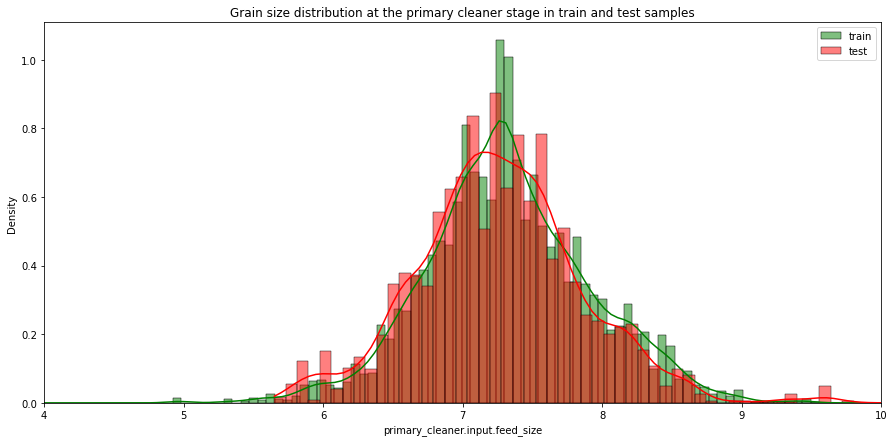

In [25]:
plt.figure(figsize=(15,7))
sns.histplot(x=df_train['primary_cleaner.input.feed_size'], kde=True, color='green', stat='density', label='train')
sns.histplot(x=df_test['primary_cleaner.input.feed_size'], kde=True, color='red', stat='density', label='test')
plt.xlim(4,10)
plt.title('Grain size distribution at the primary cleaner stage in train and test samples')
plt.legend()
plt.show()

Finally, let's examine the total concentration of ag, au and pb at different stages: in feed, after the rougher and in final concentrate. 

Each row is one of many experiments (attempts) to get gold. For each observation we sum ag, au and pb in feed ( rougher.input.feed), in concentrate after the rougher (rougher.output.concentrate), and in final concentrate (final.output.concentrate). Thus, each sum is the total value for three metals at one of the observed stages. Next, we visuilize resulted variables.

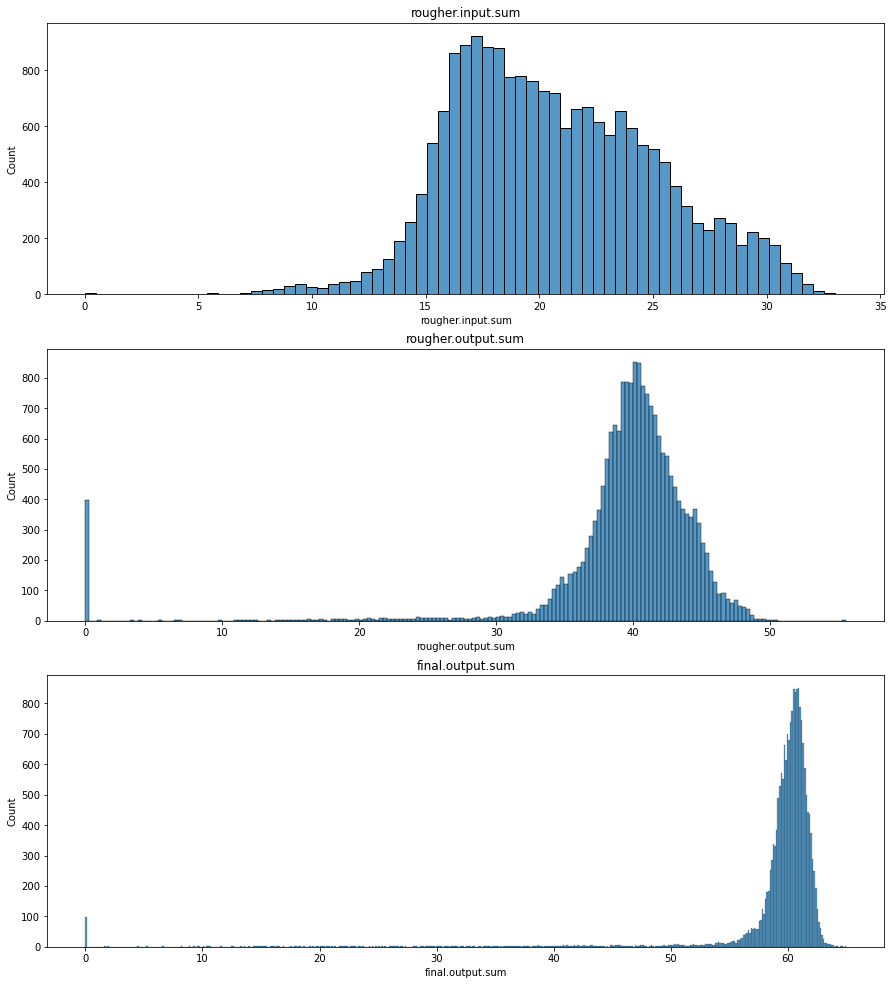

In [26]:
df_full['rougher.input.sum'] = sum([df_full['rougher.input.feed_ag'], df_full['rougher.input.feed_au'], df_full['rougher.input.feed_pb']])
df_full['rougher.output.sum'] = sum([df_full['rougher.output.concentrate_ag'], df_full['rougher.output.concentrate_au'], df_full['rougher.output.concentrate_pb']])
df_full['final.output.sum'] = sum([df_full['final.output.concentrate_ag'], df_full['final.output.concentrate_au'], df_full['final.output.concentrate_pb']])

stage_names = ['rougher.input.sum', 'rougher.output.sum', 'final.output.sum']
_, axs = plt.subplots(3, 1, figsize=(15,17))
axs = axs.ravel()    

for i in range(len(stage_names)):
    ax = axs[i]
    sns.histplot(ax=ax, x=df_full[stage_names[i]])
    ax.tick_params(axis='x')
    ax.set_title(stage_names[i])

**Summary:** We observe outliers at zeros for the total concentration of all metalls after rougher and at the final stage. They should be removed from sample. To do this, we will use unique date and time values when zero sums were recorded for to removing outliers from the sample.

In [27]:
# use the function to get the unique date of the experiment where outliers are observed
df_full.apply(date_picker, axis=1)

# date – list that is created at the very beginning, used to store the date when the function is run
date[:5]

['2016-01-16 21:00:00',
 '2016-01-16 22:00:00',
 '2016-01-16 23:00:00',
 '2016-01-17 00:00:00',
 '2016-01-17 02:00:00']

In [28]:
print('Shape of data frames before dropping outliers')
print(df_full.shape)
print(df_train.shape)
print(df_test.shape)
print()

print('Shape of data frames after dropping outliers')
df_full = df_full.query('date not in @date').copy()
print(df_full.shape)

df_train = df_train.query('date not in @date').copy()
print(df_train.shape)

df_test = df_test.query('date not in @date').copy()
print(df_test.shape)

Shape of data frames before dropping outliers
(19439, 90)
(14149, 87)
(5290, 53)

Shape of data frames after dropping outliers
(18949, 90)
(13795, 87)
(5154, 53)


Let's check whether we managed to drop outliers.

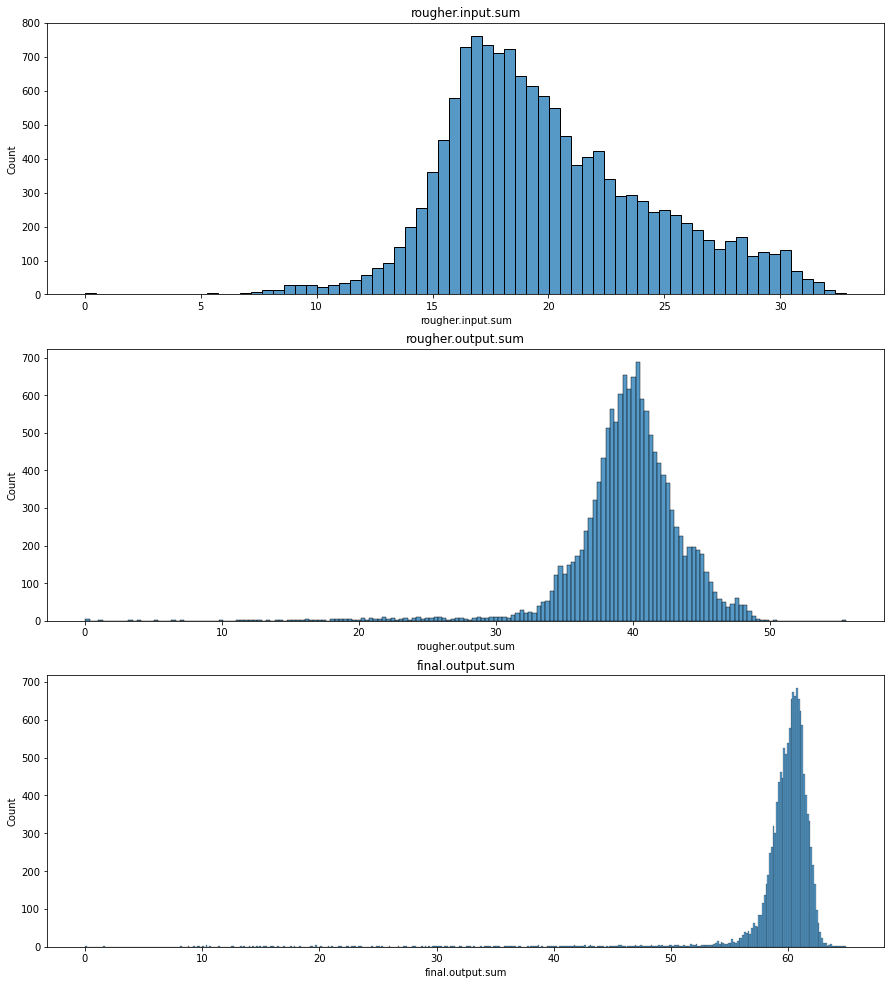

In [29]:
df_train['rougher.input.sum'] = sum([df_train['rougher.input.feed_ag'], df_train['rougher.input.feed_au'], df_train['rougher.input.feed_pb']])
df_train['rougher.output.sum'] = sum([df_train['rougher.output.concentrate_ag'], df_train['rougher.output.concentrate_au'], df_train['rougher.output.concentrate_pb']])
df_train['final.output.sum'] = sum([df_train['final.output.concentrate_ag'], df_train['final.output.concentrate_au'], df_train['final.output.concentrate_pb']])

stage_names = ['rougher.input.sum', 'rougher.output.sum', 'final.output.sum']
_, axs = plt.subplots(3, 1, figsize=(15,17))
axs = axs.ravel()    

for i in range(len(stage_names)):
    ax = axs[i]
    sns.histplot(ax=ax, x=df_train[stage_names[i]])
    ax.tick_params(axis='x')
    ax.set_title(stage_names[i])

**Summary:** We managed to identify outliers, analyzed them, and dropped them from the train and test samples. In addition, we analyzed grain size distributions and made sure that they are the same on the train and test samples.

## Models for predicting the rougher and final output recovery

Next, we will fit different models and compare sMAPE scores (Symmetric Mean Absolute Percentage Error) in cross-validation. For each of two targets (`rougher.output.recovery` and `final.output.recovery`) the best model will be selected and tested.

To begin with, we will remove from the train sample features that are absent in the test sample (except for the target ones), since **this data is not available at the decision-making stage.**

In [30]:
print(df_train.shape)

# create the to_drop variable and assign to it list of features names that are needed to be removed from the train sample
# excluding target variable because we need to keep it in train sample

to_drop = df_train[different_vars].drop(columns=['rougher.output.recovery', 'final.output.recovery']) 
df_train.drop(columns=df_train[to_drop.columns], axis=1, inplace=True)

# drop stage_names from the train sample - the total concentration of all substances at different stages
# it was calculated only to check whether the outliers were removed from the train sample, it is not needed for model fitting
df_train.drop(columns=stage_names, axis=1, inplace=True)

print(df_train.shape)

(13795, 90)
(13795, 55)


Now train and test samples have the same features. The only difference is that there are no target variables in the test sample.

In [31]:
different_vars = [var for var in df_train.columns if var not in df_test.columns]
print(different_vars)

['final.output.recovery', 'rougher.output.recovery']


Next, let's add target variables - `final.output.recovery` and `rougher.output.recovery` – to the test smaple.

In [32]:
df_test = df_test.join(df_full[['date', 'final.output.recovery', 'rougher.output.recovery']].set_index('date'), on='date')
display.display(df_test.head(3))

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,final.output.recovery,rougher.output.recovery
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414,70.273583,89.993421
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438,68.910432,88.089657
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559,68.143213,88.412756


Let's check that the `join` was implemented correctly: display the values of the `final.output.recovery` variable in the full and test samples for 2016-09-01 00:59:59.

In [33]:
df_full.loc[df_full['date'] == '2016-09-01 00:59:59', 'final.output.recovery'], df_test.loc[df_test['date'] == '2016-09-01 00:59:59', 'final.output.recovery']

(4682    70.273583
 Name: final.output.recovery, dtype: float64,
 0    70.273583
 Name: final.output.recovery, dtype: float64)

Let's drop missing values from the test data sample.

In [34]:
df_test.dropna(inplace=True)

To calculate the metric sMAPE, we will use the `smape` function, which was initialized at the very beginning.

sMAPE - (Eng. Symmetric Mean Absolute Percentage Error, "symmetric mean absolute percentage deviation") - a quality metric similar to MAE. However, it is relative score: it equally takes into account the scale of both the target feature and the prediction.

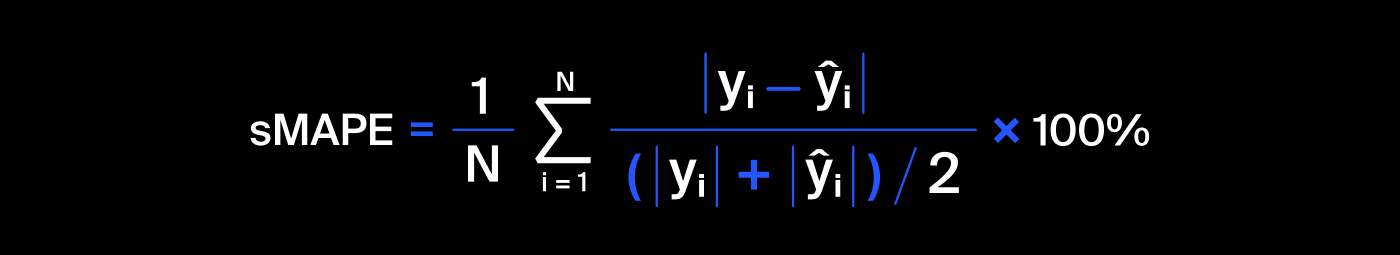

In [204]:
display.Image("https://pictures.s3.yandex.net/resources/smape_1576239058.jpg")

* $y_i$ – target variable for $i^{th}$ observation in the sample on which the quality is measured
* $y_{hat_i}$ – prediction for $i^{th}$ observation
* N – number of observations
* sum – summation over all observations (i varies from 1 to N)

Let's create `scorer_smape` – an object that will allow us to use our metric in GridSearchCV to select parameters and assess the model.

In [35]:
scorer_smape = make_scorer(smape, greater_is_better=False)

Finally, let's select features and targets from the train and test sample and assign them to separate variables. Then we check the shapes.

In [38]:
features_train, features_test = df_train.drop(['final.output.recovery', 'rougher.output.recovery', 'date'], axis=1), df_test.drop(['final.output.recovery', 'rougher.output.recovery', 'date'], axis=1)
print(features_train.shape, features_test.shape)

target_rougher_train, target_rougher_test = df_train['rougher.output.recovery'], df_test['rougher.output.recovery']
print(target_rougher_train.shape, target_rougher_test.shape)

target_final_train, target_final_test = df_train['final.output.recovery'], df_test['final.output.recovery']
print(target_final_train.shape, target_final_test.shape)

(13795, 52) (5105, 52)
(13795,) (5105,)
(13795,) (5105,)


At the next stage, we fit decision tree, random forest, and linear regression models. Using GridSearchCV we search for the best parameters of the model.

### Rougher output recovery

#### Decision Tree Regressor

In [39]:
params_tree = {'max_depth': range(20,30,2),
               #'min_samples_leaf': range(1,4),
               'min_samples_split': range(20,30,2)}

folds = KFold(n_splits = 5, shuffle = True, random_state = 42)
grid_tree = GridSearchCV(DecisionTreeRegressor(random_state=42), params_tree, cv=folds, scoring=scorer_smape)

In [40]:
%%time
grid_tree.fit(features_train, target_rougher_train)

CPU times: user 1min 42s, sys: 386 ms, total: 1min 42s
Wall time: 1min 42s


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=DecisionTreeRegressor(random_state=42),
             param_grid={'max_depth': range(20, 30, 2),
                         'min_samples_split': range(20, 30, 2)},
             scoring=make_scorer(smape, greater_is_better=False))

In [66]:
print(grid_tree.best_params_)
print(-grid_tree.best_score_)
print(grid_tree.best_estimator_)

{'max_depth': 24, 'min_samples_split': 28}
3.402268341467372
DecisionTreeRegressor(max_depth=24, min_samples_split=28, random_state=42)


Let's visualize predictions.

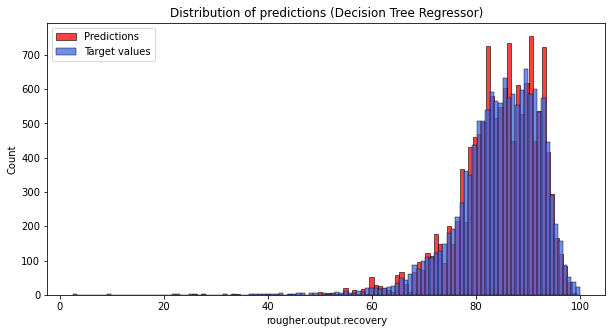

In [54]:
plt.figure(figsize=(10,5))
sns.histplot(x=grid_tree.predict(features_train), color='red', label='Predictions')
sns.histplot(x=target_rougher_train, color='royalblue', label='Target values')
plt.legend()
plt.title('Distribution of predictions (Decision Tree Regressor)')
plt.show()

#### Random Forest Regressor

In [50]:
params_forest = {'max_depth': range(20,30,2),
                 #'min_samples_leaf': range(1,4),
                 'n_estimators': range(10,30,10)}

folds = KFold(n_splits = 5, shuffle = True, random_state = 42)
grid_forest = GridSearchCV(RandomForestRegressor(random_state=42), params_forest, cv=folds, scoring=scorer_smape)

In [51]:
%%time
grid_forest.fit(features_train, target_rougher_train)

CPU times: user 7min 3s, sys: 1.25 s, total: 7min 4s
Wall time: 7min 4s


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': range(20, 30, 2),
                         'n_estimators': range(10, 30, 10)},
             scoring=make_scorer(smape, greater_is_better=False))

In [52]:
print(grid_forest.best_params_)
print(-grid_forest.best_score_)
print(grid_forest.best_estimator_)

{'max_depth': 26, 'n_estimators': 20}
2.66879385737892
RandomForestRegressor(max_depth=26, n_estimators=20, random_state=42)


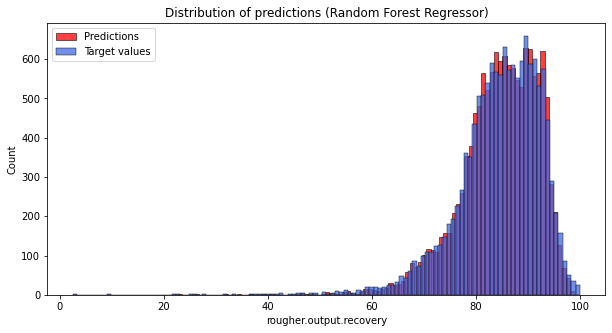

In [53]:
plt.figure(figsize=(10,5))
sns.histplot(x=grid_forest.predict(features_train), color='red', label='Predictions')
sns.histplot(x=target_rougher_train, color='royalblue', label='Target values')
plt.legend()
plt.title('Distribution of predictions (Random Forest Regressor)')
plt.show()

Let's estimate the importance of features. We create a column with "noise" (random values from a normal distribution), fit Random Forest Regressor and visualize `feature_importance_`. If there are features less important than noise we can drop it.

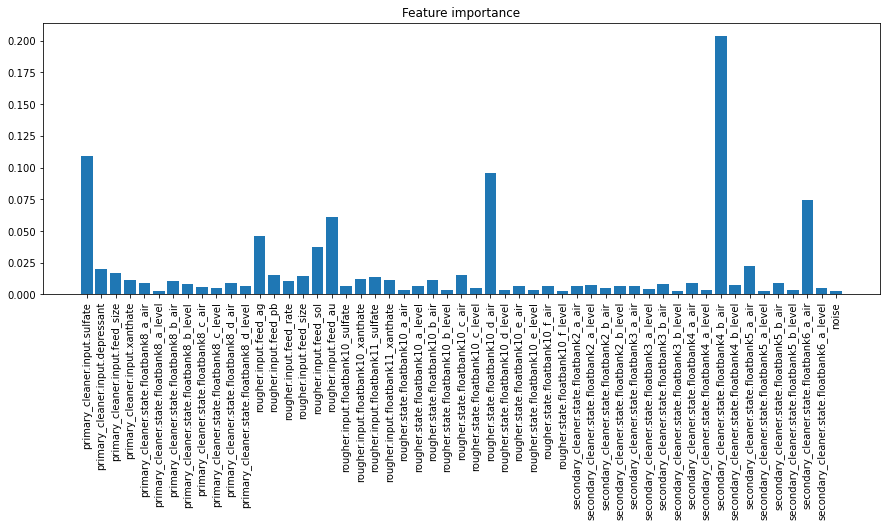

In [56]:
best_feat = features_train.copy()

best_feat["noise"] = np.random.randn(len(best_feat))
feature_importance = grid_forest.best_estimator_.fit(best_feat, target_rougher_train)

plt.figure(figsize=(15,5))
plt.bar(best_feat.columns, feature_importance.feature_importances_)
plt.xticks(rotation = 90)
plt.title('Feature importance')
plt.show()

**Summary:** Technically, all features are more important than the noise we added to the sample. Next, let's display the most important features using `SelectFromModel`.

In [57]:
best_feat = SelectFromModel(grid_forest.best_estimator_)
best_feat.fit(features_train, target_rougher_train)
best_feat.transform(features_train)
features_names = features_train.columns
features_names[best_feat.get_support()]

Index(['primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'rougher.input.feed_ag', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.state.floatbank10_d_air',
       'secondary_cleaner.state.floatbank4_b_air',
       'secondary_cleaner.state.floatbank5_a_air',
       'secondary_cleaner.state.floatbank6_a_air'],
      dtype='object')

**Summary:** We see that these are the same features that stand out in the graph above. We will use all features to fit the model, since we could not select those that are unimportant.

#### Linear Regression

In [60]:
# we use pipeline to avoid data leakage problem

pipe = Pipeline([('scaler', StandardScaler()),
                 ('lin_model', LinearRegression())])

folds = KFold(n_splits = 5, shuffle = True, random_state = 42)

print(np.mean(-cross_val_score(pipe, features_train, target_rougher_train, 
                               cv=folds, scoring=scorer_smape)))

4.665943692678814


In [61]:
pipe.fit(features_train, target_rougher_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('lin_model', LinearRegression())])

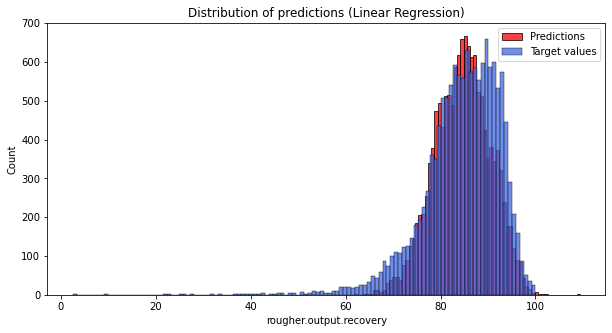

In [62]:
plt.figure(figsize=(10,5))
sns.histplot(x=pipe.predict(features_train), color='red', label='Predictions')
sns.histplot(x=target_rougher_train, color='royalblue', label='Target values')
plt.legend()
plt.title('Distribution of predictions (Linear Regression)')
plt.show()

### Final output recovery

#### Decision Tree Regressor

In [63]:
params_tree_final = {'max_depth': range(10,30,2),
                     'min_samples_split': range(20,30,2)}

folds = KFold(n_splits = 5, shuffle = True, random_state = 42)
grid_tree_final = GridSearchCV(DecisionTreeRegressor(random_state=42), params_tree_final, cv=folds, scoring=scorer_smape)

In [64]:
%%time
grid_tree_final.fit(features_train, target_final_train)

CPU times: user 3min 32s, sys: 347 ms, total: 3min 32s
Wall time: 3min 33s


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=DecisionTreeRegressor(random_state=42),
             param_grid={'max_depth': range(10, 30, 2),
                         'min_samples_split': range(20, 30, 2)},
             scoring=make_scorer(smape, greater_is_better=False))

In [77]:
print(grid_tree_final.best_params_)
print(-grid_tree_final.best_score_)
print(grid_tree_final.best_estimator_)

{'max_depth': 14, 'min_samples_split': 28}
7.263039772045741
DecisionTreeRegressor(max_depth=14, min_samples_split=28, random_state=42)


Let's visualize results of model fitting. We can see that our model does not predict values well.

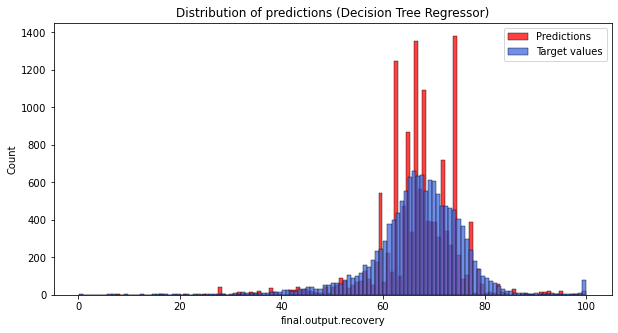

In [65]:
plt.figure(figsize=(10,5))
sns.histplot(x=grid_tree_final.predict(features_train), color='red', label='Predictions')
sns.histplot(x=target_final_train, color='royalblue', label='Target values')
plt.legend()
plt.title('Distribution of predictions (Decision Tree Regressor)')
plt.show()

#### Random Forest Regressor

In [66]:
params_forest_final = {'max_depth': range(25,35,2),
                       'n_estimators': range(15,30,5)}

folds = KFold(n_splits = 5, shuffle = True, random_state = 42)
grid_forest_final = GridSearchCV(RandomForestRegressor(random_state=42), params_forest_final, cv=folds, scoring=scorer_smape)

In [67]:
%%time
grid_forest_final.fit(features_train, target_final_train)

CPU times: user 16min 24s, sys: 2.94 s, total: 16min 27s
Wall time: 16min 28s


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': range(25, 35, 2),
                         'n_estimators': range(15, 30, 5)},
             scoring=make_scorer(smape, greater_is_better=False))

In [68]:
print(grid_forest_final.best_params_)
print(-grid_forest_final.best_score_)
print(grid_forest_final.best_estimator_)

{'max_depth': 27, 'n_estimators': 25}
5.929331857344046
RandomForestRegressor(max_depth=27, n_estimators=25, random_state=42)


Let's visualize results of model fitting. Random Forest Regressor model predicts values well.

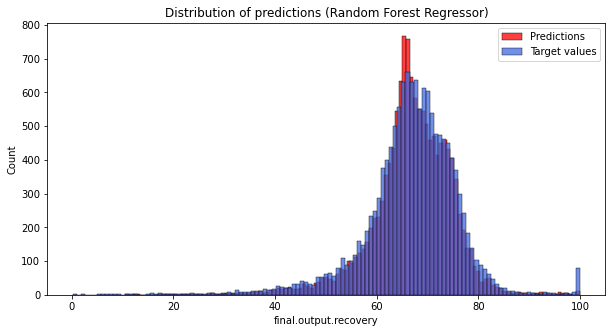

In [69]:
plt.figure(figsize=(10,5))
sns.histplot(x=grid_forest_final.predict(features_train), color='red', label='Predictions')
sns.histplot(x=target_final_train, color='royalblue', label='Target values')
plt.legend()
plt.title('Distribution of predictions (Random Forest Regressor)')
plt.show()

Now let's estimate the importance of features using the same techniques we used at previous stage.

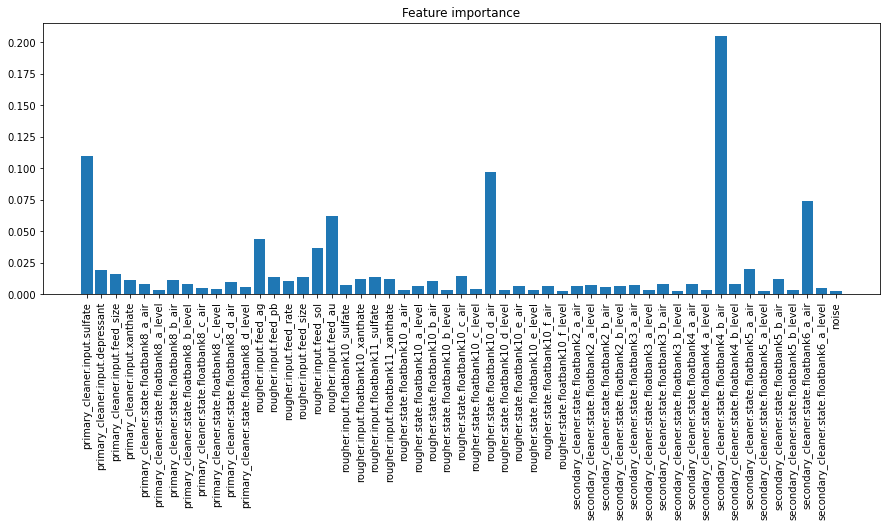

In [71]:
best_feat = features_train.copy()

best_feat["noise"] = np.random.randn(len(best_feat))
feature_importance_final = grid_forest_final.best_estimator_.fit(best_feat, target_rougher_train)

plt.figure(figsize=(15,5))
plt.bar(best_feat.columns, feature_importance_final.feature_importances_)
plt.xticks(rotation = 90)
plt.title('Feature importance')
plt.show()

In [72]:
best_feat = SelectFromModel(grid_forest_final.best_estimator_)
best_feat.fit(features_train, target_rougher_train)
best_feat.transform(features_train)
features_names = features_train.columns
features_names[best_feat.get_support()]

Index(['primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'rougher.input.feed_ag', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.state.floatbank10_d_air',
       'secondary_cleaner.state.floatbank4_b_air',
       'secondary_cleaner.state.floatbank5_a_air',
       'secondary_cleaner.state.floatbank6_a_air'],
      dtype='object')

**Summary:** No features are less significant than noise. We will use all variables to train the models.

#### Linear Regression

In [76]:
pipe_final = Pipeline([('scaler', StandardScaler()),
                 ('lin_model', LinearRegression())])

folds = KFold(n_splits = 5, shuffle = True, random_state = 42)
print(np.mean(-cross_val_score(pipe_final, features_train, target_final_train, 
                               cv=folds, scoring=scorer_smape)))

8.160431865877499


In [77]:
pipe_final.fit(features_train, target_rougher_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('lin_model', LinearRegression())])

On the graph you can clearly see why it is important for us to consider the scale of both the target feature and the prediction (sMAPE score).

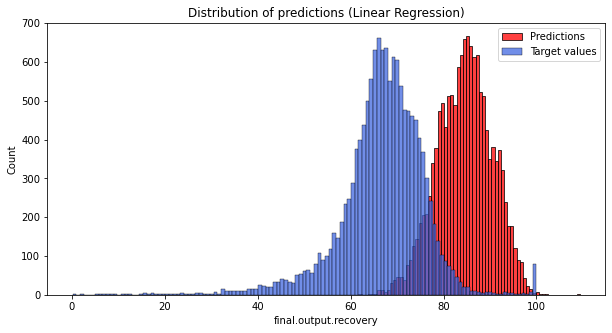

In [78]:
plt.figure(figsize=(10,5))
sns.histplot(x=pipe_final.predict(features_train), color='red', label='Predictions')
sns.histplot(x=target_final_train, color='royalblue', label='Target values')
plt.legend()
plt.title('Distribution of predictions (Linear Regression)')
plt.show()

### Test checks

As a result, Random Forest Regressor better than other models predicts the efficiency of the rough and final concentrate recovery.

In [80]:
params_rougher = {'max_depth': 26, 'n_estimators': 20}
forest_rougher = RandomForestRegressor(random_state=42).set_params(**params_rougher)
forest_rougher.fit(features_train, target_rougher_train)

RandomForestRegressor(max_depth=26, n_estimators=20, random_state=42)

In [84]:
rougher_score = smape(np.array(target_rougher_test), forest_rougher.predict(features_test))
print('sMAPE score for the predictions of the rough concentrate recovery on test sample:', rougher_score)

sMAPE score for the predictions of the rough concentrate recovery on test sample: 4.354202008799191


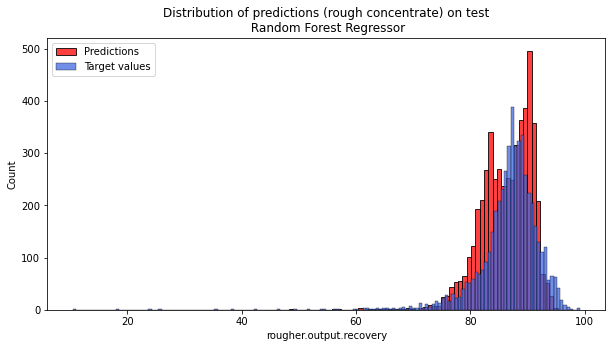

In [82]:
plt.figure(figsize=(10,5))
sns.histplot(x=forest_rougher.predict(features_test), color='red', label='Predictions')
sns.histplot(x=target_rougher_test, color='royalblue', label='Target values')
plt.legend()
plt.title('Distribution of predictions (rough concentrate) on test\n Random Forest Regressor')
plt.show()

In [83]:
params_final = {'max_depth': 27, 'n_estimators': 25}
forest_final = RandomForestRegressor(random_state=42).set_params(**params_final)
forest_final.fit(features_train, target_final_train)

RandomForestRegressor(max_depth=27, n_estimators=25, random_state=42)

In [85]:
final_concentrate_score = smape(np.array(target_final_test), forest_final.predict(features_test))
print('sMAPE score for the predictions of the final concentrate recovery on test sample:', final_concentrate_score)

sMAPE score for the predictions of the final concentrate recovery on test sample: 8.173967710377006


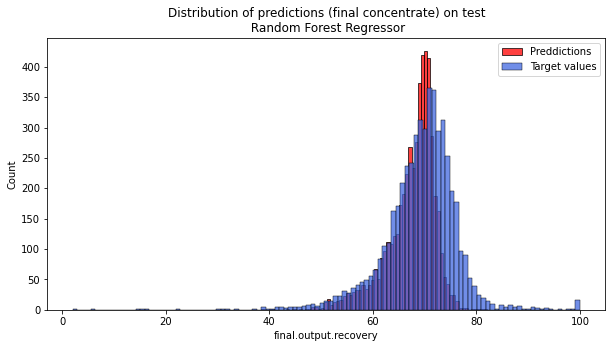

In [86]:
plt.figure(figsize=(10,5))
sns.histplot(x=forest_final.predict(features_test), color='red', label='Preddictions')
sns.histplot(x=target_final_test, color='royalblue', label='Target values')
plt.legend()
plt.title('Distribution of predictions (final concentrate) on test\n Random Forest Regressor')
plt.show()

Let's calculate total sMAPE. We will use function `final_smape`, that was initialized at the beginning.

In [87]:
final_score = final_smape(rougher_score, final_concentrate_score)
print(final_score)

7.219026284982553


Let's compare our results with DummyRegressor.

In [88]:
dummy_reg = DummyRegressor()
dummy_reg.fit(features_train, target_rougher_train)
dummy_rough = smape(target_rougher_test, dummy_reg.predict(features_test))
print(dummy_rough)

5.297058820770408


In [89]:
dummy_reg_final = DummyRegressor()
dummy_reg_final.fit(features_train, target_final_train)
dummy_final = smape(target_final_test, dummy_reg_final.predict(features_test))
print(dummy_final)

8.463283629208318


In [90]:
final_score = final_smape(dummy_rough, dummy_final)
print(final_score)

7.6717274270988405


**Summary:** Random Forest Regressor predicts slightly better than the constant model.

## Concluscion

At the preprocessing stage, we examined the data, filled in the missing values; revealed multicollinearity and determined its nature; made sure that the recovery efficiency was calculated correctly; determined what variables were missing in the test sample, explained the reason for their absence, dropped them from the train sample. During data analysis, we identified outliers and removed them.

Then, the best model for predicting the efficiency of the recovery of rough and final concentrates was chosen. It is *Random Forest Regressor*. This model better predicts both the recovery of rough and final concentrate. The quality of the model was assessed using the sMAPE metric, the final value of which for the rough and final concentrate was calculated in proportion 25:75 respectively, and totalled 7.28. Thus, the process of gold recovery from gold ore was simulated.